# Calendar Spread Payoff

A calendar spread strategy profits from the time decay and/or increase in the implied volatility of the options. In this notebook, we will create a payoff graph of calendar spread at the expiry of front-month option.

## Importing The Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
# BS Model
import mibian

## Setup Of A Calendar Spread Strategy
Calendar spread involves options of the same underlying asset, the same strike price but with different expiration dates. 

- If a Call or Put is Sold with near-term expiration it is called the _front month_
- If a Call or Put is Bought with long-term expiration it is called the _back month_

## Calendar Spread On Nifty
We will setup the Calendar Spread on Nifty as shown below at the same Strike Price

- Sell 11013.10 strike call @ INR 85.20 expiring on 27 July 2018 : _front month_
- Buy 11013.10 strike call @ INR 201.70 expiring on 30 August 2018 : _back month_

In [3]:
# Nifty futures price (Assumed)
nifty_jul_fut = 11030.50
nifty_aug_fut = 11046.40

strike_price = 11013.10
jul_call_price = 85.20
aug_call_price = 201.70
setup_cost = aug_call_price - jul_call_price

days_to_expiry_jul_call = 7
days_to_expiry_aug_call = 41

# Range of values for Nifty
sT = np.arange(0.92*nifty_jul_fut,1.1*nifty_aug_fut,1) 

#interest rate for input to Black-Scholes model
interest_rate = 0.0

## Implied Volatility (IV)

We calculate the IV using Black Scholes model for the front-month and back-month call option.
To calculate the call price for different values of Nifty, this IV will be used later as an input to Black-Scholes model.

In [4]:
# Front-month IV
jul_call_iv = mibian.BS([nifty_jul_fut, strike_price, interest_rate, days_to_expiry_jul_call], 
                        callPrice=jul_call_price).impliedVolatility
print ("Front Month IV %.2f" % jul_call_iv,"%")

# Back-month IV
aug_call_iv = mibian.BS([nifty_aug_fut, strike_price, interest_rate, days_to_expiry_aug_call], 
                        callPrice=aug_call_price).impliedVolatility
print ("Back Month IV %.2f" % aug_call_iv,"%")

Front Month IV 12.51 %
Back Month IV 12.52 %


## Calculating The Call Price For Front And Back Month Option

Since, there are two expiration dates for the options in the calendar spread, Black-Scholes pricing model is used to guesstimate the price of the front-month and back-month 11013.10 strike call at the front-month call expiry. 

Note: Implied volatility and interest rates are assumed to remain constant.

In [5]:
# Changing days to expiry to a day before the front-month expiry
days_to_expiry_jul_call = 0.001
days_to_expiry_aug_call = 41 - days_to_expiry_jul_call

df = pd.DataFrame()
df['nifty_price'] = sT
df['jul_call_price'] = np.nan
df['aug_call_price'] = np.nan

# Calculating call price for different possible values of Nifty
for i in range(0,len(df)):
    df.loc[i,'jul_call_price'] = mibian.BS([df.iloc[i]['nifty_price'], strike_price, interest_rate, days_to_expiry_jul_call], 
                                           volatility=jul_call_iv).callPrice
    
    # Since, interest rate is considered 0%, 35 is added to the nifty price to get the Nifty August futures price. 
    df.loc[i,'aug_call_price'] = mibian.BS([df.iloc[i]['nifty_price']+35, strike_price, interest_rate, days_to_expiry_aug_call], 
                                           volatility=aug_call_iv).callPrice
df.head()

,nifty_price,jul_call_price,aug_call_price
0,10148.06,0.0,5.332499
1,10149.06,0.0,5.364952
2,10150.06,0.0,5.397576
3,10151.06,0.0,5.430371
4,10152.06,0.0,5.463337


## Calendar Spread Payoff

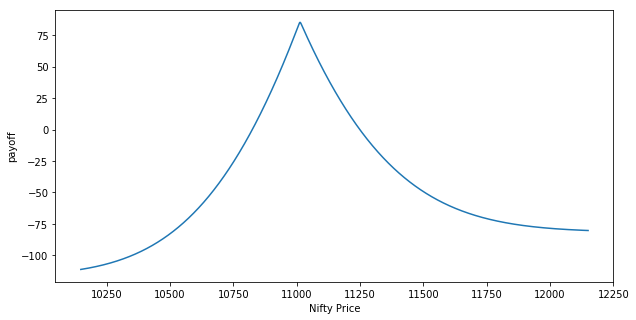

In [6]:
df['payoff'] = df.aug_call_price - df.jul_call_price - setup_cost
plt.figure(figsize=(10,5))
plt.ylabel("payoff")
plt.xlabel("Nifty Price")
plt.plot(sT,df.payoff)
plt.show()

Graph Interpretation:

*Max Profit*: When the Nifty price (on expiry of front-month) is at the strike price of INR 11013.10. It decreases when we move in either direction away from the Strike Price.

*Max Loss*: When the option moves deep ITM (In-The-Money) or deep OTM (Out-of-The-Money).